# Fine Tuning NASNetLarge terhadap dataset DeepFashion

Berikut adalah jupyter notebook untuk fine tuning terhadap arsitektur NASNetLarge tersebut supaya bisa digunakan untuk memprediksi dataset DeepFashion.

## DeepFashion

Merupakan sebuah dataset clothing yang tersedia secara publik. Detail mengenai dataset ini bisa ditemukan di http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html

## Langkah Fine Tuning

Secara garis besar, berikut adalah langkah fine tuning yang dilakukan pada penelitian ini:
1. Image augmentation untuk data training dan validation
2. Instansiasi arsitektur model asli dari keras, dan menghilangkan top layer-nya
3. Menambahkan beberapa layer untuk menggantikan top layer model
4. Set-up fine tuning
5. Training model
6. Testing model

Berikut langkah-langkah tersebut

In [1]:
import os, sys, glob, datetime, time, pytz

from keras import __version__

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
# Defining variables
EPOCHS        = 100
BAT_SIZE      = 20
FROZEN_LAYERS = 950
DATA_SET_DIR  = '/home/jupyter/deepfashion-dataset/' # clothing dataset 10.000

WIDTH, HEIGHT = 331, 331
FC_SIZE       = 256

TRAIN_DIR        = DATA_SET_DIR + 'train'
VALIDATION_DIR   = DATA_SET_DIR + 'val'
TEST_DIR         = DATA_SET_DIR + 'test'
nb_classes       = len(glob.glob(TRAIN_DIR + "/*"))

timezone = pytz.timezone("Asia/Jakarta")

now = timezone.localize(datetime.datetime.now())

## 1. Image augmentation untuk data training dan validation

Di bawah ini adalah langkah pertama yang dilakukan.

Found 209222 images belonging to 46 classes.
Found 40000 images belonging to 46 classes.
Found 40000 images belonging to 46 classes.


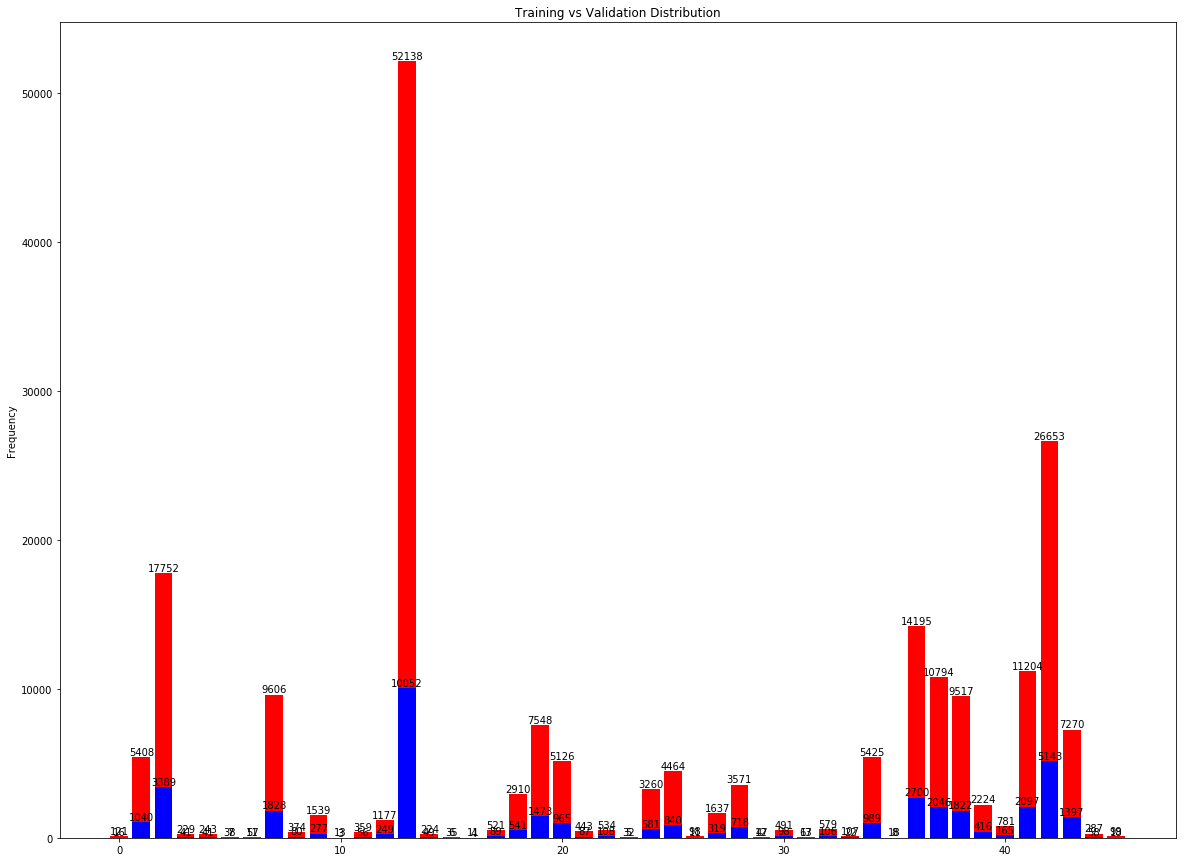

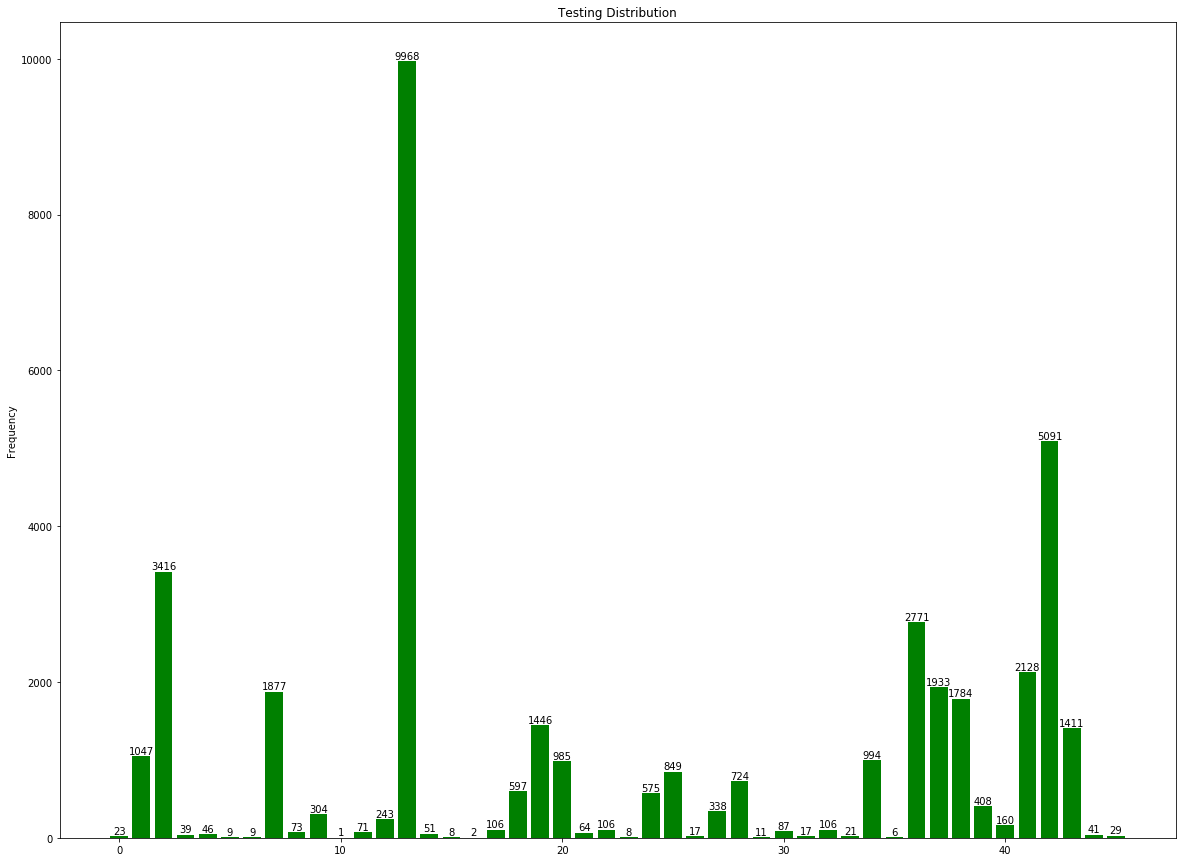

[3.75892921e+01 8.41032609e-01 2.56213629e-01 1.98615910e+01
 1.87173018e+01 1.19692220e+02 7.97948131e+01 4.73485774e-01
 1.21612416e+01 2.95536345e+00 3.49869565e+02 1.26693714e+01
 3.86431975e+00 8.72358807e-02 2.03049301e+01 1.29951553e+02
 4.13482213e+02 8.72995076e+00 1.56299118e+00 6.02584042e-01
 8.87300887e-01 1.02670527e+01 8.51742387e+00 1.42134511e+02
 1.39518538e+00 1.01888538e+00 4.64112689e+01 2.77843882e+00
 1.27367806e+00 9.67724329e+01 9.26334898e+00 7.21953071e+01
 7.85544792e+00 4.25075173e+01 8.38397115e-01 2.52683575e+02
 3.20415946e-01 4.21373388e-01 4.77913665e-01 2.04510088e+00
 5.82369315e+00 4.05953619e-01 1.70648871e-01 6.25626458e-01
 1.58477503e+01 4.59424682e+01]
Training Sample


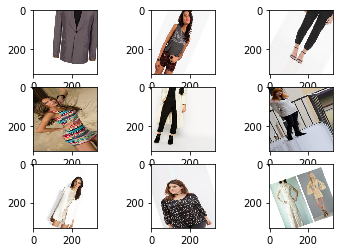

Validation Sample


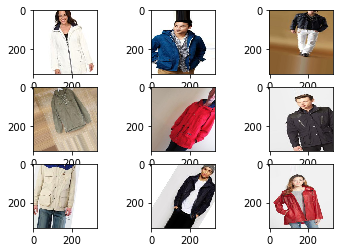

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen =  ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BAT_SIZE
)

validation_generator = train_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BAT_SIZE,
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BAT_SIZE,
    shuffle=False
)

width = 0.8 # width of the bars

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+2,
                '%d' % int(height),
                ha='center', va='bottom')

fig, ax = plt.subplots()
unique, counts = np.unique(train_generator.classes, return_counts=True)
rects1 = ax.bar(unique, counts, width, color='r')
unique, counts = np.unique(validation_generator.classes, return_counts=True)
rects2 = ax.bar(unique, counts, width, color='b')

fig.set_figheight(15)
fig.set_figwidth(20)
ax.set_ylabel('Frequency')
ax.set_title('Training vs Validation Distribution')

autolabel(rects1)
autolabel(rects2)

plt.show()

fig, ax = plt.subplots()
unique, counts = np.unique(test_generator.classes, return_counts=True)
rects1 = ax.bar(unique, counts, width, color='g')

fig.set_figheight(15)
fig.set_figwidth(20)
ax.set_ylabel('Frequency')
ax.set_title('Testing Distribution')

autolabel(rects1)

plt.show()

# sys.exit()

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

print(class_weights)

print('Training Sample')
x,y = train_generator.next()
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    image = x[i]
    plt.imshow(image)

plt.show()

print('Validation Sample')
x,y = validation_generator.next()
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    image = x[i]
    plt.imshow(image)

plt.show()

## 2. Instansiasi arsitektur NASNetLarge dari keras, dan menghilangkan top layer-nya

Berikutnya adalah instansiasi arsitektur NASNetLarge. NASNetLarge sendiri sudah tersedia secara built-in di dalam keras. Maka dari itu proses instansiasi-nya menjadi sangat sederhana.

Berikut adalah proses instansiasi tersebut

In [4]:
from keras.applications.nasnet import NASNetLarge

from keras.utils.vis_utils import plot_model

base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, 3))

print('Model asli tanpa top layer terdiri dari %d layer' % len(base_model.layers))

W0725 13:12:07.367381 139729816372992 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 13:12:07.398629 139729816372992 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 13:12:07.403401 139729816372992 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0725 13:12:07.428524 139729816372992 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0725 13:12:07.429394

Model asli tanpa top layer terdiri dari 1039 layer


## 3. Menambahkan beberapa layer untuk menggantikan top layer NASNetLarge

Pada instansiasi di langkah sebelumnya layer classifier atau layer paling atas tida diikut sertakan. Maka pada langkah ini akan dibuat layer baru yang digunakan sebagai pengganti yang tidak diikut sertakan.

Berikut adalah langkah tersebut

In [5]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model

x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
x = Dropout(0.5)(x)
classifier = Dense(nb_classes, activation='softmax')(x) #new softmax layer

model = Model(inputs=base_model.input, outputs=classifier)

print('Model baru terdiri dari %d layer' % (len(model.layers)))

W0725 13:13:00.107059 139729816372992 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model baru terdiri dari 1043 layer


## 4. Set-up fine tuning

Langkah ini dilakukan untuk menentukan layer mana saja yang akan ditraining dan tidak ditraining.

Berikut adalah langkahnya.

In [6]:
from keras.optimizers import SGD
from keras.metrics import top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

for layer in model.layers[:FROZEN_LAYERS]:
    layer.trainable = False
for layer in model.layers[FROZEN_LAYERS:]:
    layer.trainable = True

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy', top_3_accuracy, 'top_k_categorical_accuracy'])
# model.summary()

W0725 13:13:00.291571 139729816372992 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## 5. Training model

Langkah berikutnya adalah training model yang telah di set-up pada langkah sebelumnya.

Berikut adalah langkahnya

In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from sklearn.metrics import classification_report, confusion_matrix

import time
class ConsoleLog(Callback):
    def __init__(self, filename):
        self.filename = filename
        self.log_file = open(self.filename, 'w')
        self.log_file.write("epoch, time, acc, val_acc\n")
        self.log_file.close()

    def on_train_begin(self, logs={}):
        self.log_file = open(self.filename, 'a')
        self.log_file.flush()

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
        self.times = 0

    def on_epoch_end(self, epoch, logs={}):
        self.times = time.time() - self.epoch_time_start
        row = "%d, %.2f, %.4f, %.4f" % (epoch, self.times, logs['acc'], logs['val_acc'])
        self.log_file.write("%s\n" % row)
        self.log_file.flush()
        
    def on_train_end(self, logs=None):
        self.log_file.close()

training_start_datetime = timezone.localize(datetime.datetime.now()).strftime("%Y-%m-%d %H:%M:%S")
start = time.time()
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BAT_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps = validation_generator.samples // BAT_SIZE,
    class_weight=class_weights,
    callbacks=[CSVLogger('NASNetLargeDeepFashion.log'), ConsoleLog('NASNetLargeDeepFashionTimes.log')]
)
end = time.time()
training_end_datetime = timezone.localize(datetime.datetime.now()).strftime("%Y-%m-%d %H:%M:%S")
print('Training from %s to %s taking %d seconds.' % (training_start_datetime, training_end_datetime, (end - start)))

W0725 13:13:00.462539 139729816372992 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
 6953/10461 [==================>...........] - ETA: 33:20 - loss: 2.2825 - acc: 0.3922 - top_3_accuracy: 0.6022 - top_k_categorical_accuracy: 0.7130

## 6. Testing model

Langkah berikutnya adalah testing menggunakan dataset testing.

Berikut adalah langkahnya

In [8]:
# Testing
testing_start_datetime = timezone.localize(datetime.datetime.now()).strftime("%Y-%m-%d %H:%M:%S")
testing_start = time.time()
Y_pred = model.predict_generator(
    test_generator, 
    steps=test_generator.samples // BAT_SIZE,
    verbose=1
)
testing_end = time.time()
testing_end_datetime = timezone.localize(datetime.datetime.now()).strftime("%Y-%m-%d %H:%M:%S")
print('Testing from %s to %s taking %d seconds.' % (testing_start_datetime, testing_end_datetime, (testing_end - testing_start)))

2000/2000 [==============================] - 818s 409ms/step
Testing from 2019-07-25 15:10:54 to 2019-07-25 15:24:31 taking 817 seconds.


## Langkah Tambahan: Simpan model

In [9]:
# Simpan arsitektur dan weight dari model yang telah di training ke sebuah file
model.save('NASNetLargeDeepFashion.model')
print('Model tersimpan')

Model tersimpan


## Langkah tambahan: Tampilkan accuracy, loss, confusion matrix serta classification report

Langkah ini dilakukan untuk menampilkan kurva accuracy dan loss dari training yang telah dilakukan. Serta confusion matrix untuk testing. Selain itu detail laporan terkait precision, f-score dan recall juga ditampilkan di sini.

Berikut adalah langkahnya

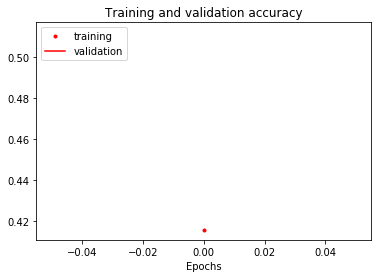

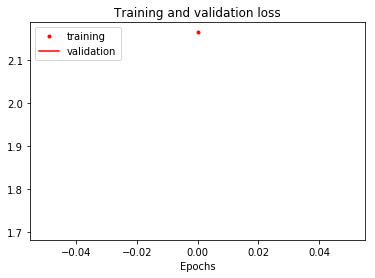

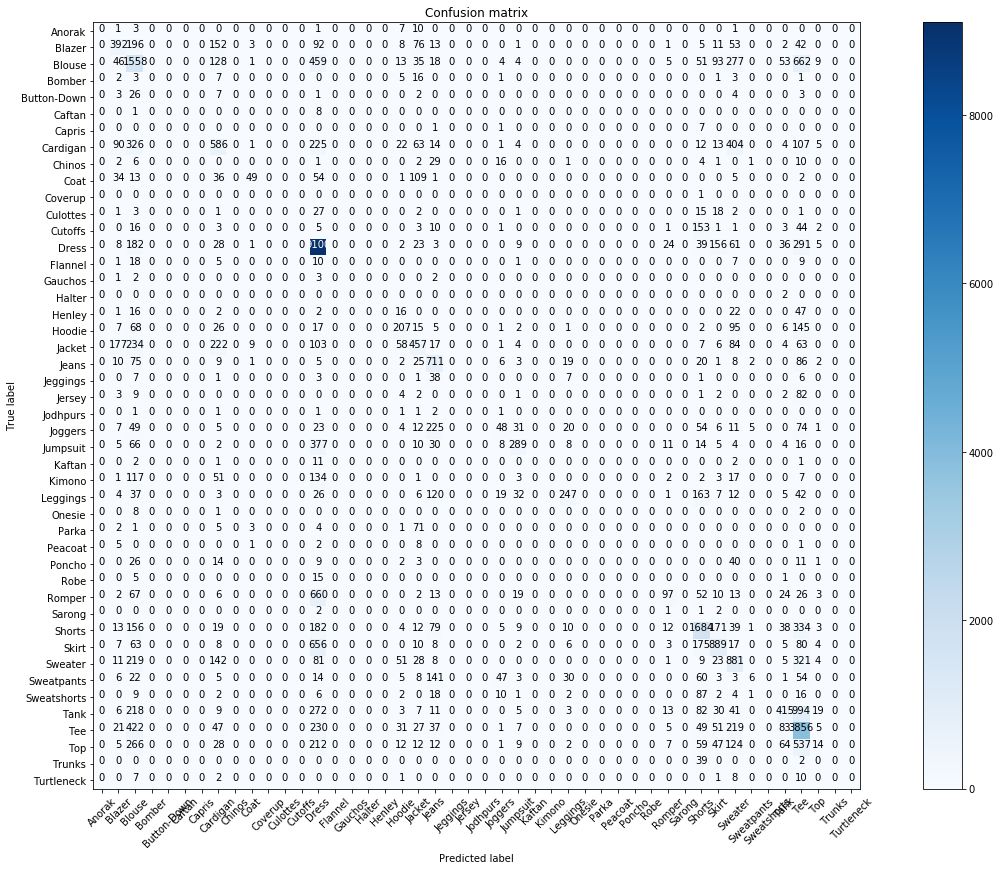

Classification Report
              precision    recall  f1-score   support

      Anorak       0.00      0.00      0.00        23
      Blazer       0.45      0.37      0.41      1047
      Blouse       0.34      0.46      0.39      3416
      Bomber       0.00      0.00      0.00        39
 Button-Down       0.00      0.00      0.00        46
      Caftan       0.00      0.00      0.00         9
      Capris       0.00      0.00      0.00         9
    Cardigan       0.37      0.31      0.34      1877
      Chinos       0.00      0.00      0.00        73
        Coat       0.71      0.16      0.26       304
     Coverup       0.00      0.00      0.00         1
    Culottes       0.00      0.00      0.00        71
     Cutoffs       0.00      0.00      0.00       243
       Dress       0.70      0.91      0.79      9968
     Flannel       0.00      0.00      0.00        51
     Gauchos       0.00      0.00      0.00         8
      Halter       0.00      0.00      0.00         2
     

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
# %matplotlib inline

# import matplotlib.pyplot as plt
import itertools
from sklearn.utils.multiclass import unique_labels

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Accuracy
plt.plot(epochs, acc, 'r.', label='training')
plt.plot(epochs, val_acc, 'r', label='validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

# Loss
plt.plot(epochs, loss, 'r.', label='training')
plt.plot(epochs, val_loss, 'r-', label='validation')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

# Confusion Matrix
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
classes = sorted(os.listdir(TEST_DIR))
plt.figure(figsize=(18,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print('Classification Report')
classification_report = classification_report(test_generator.classes, y_pred, target_names=classes)
print(classification_report)